# TIME SERIES FORECASTING OF PROJECT TWEETS BIG DATA PROCESSED WITH SPARK AND STORED IN MONGODB

# Dataset
The dataste is a large dataset gleaned from the twitter API that is called ProjectTweets.csv.

This dataset contains 1,600,000 tweets extracted using the twitter api. 


Content
It contains the following 5 fields:
- ids: The id of the tweet (eg. 4587)
- date: the date of the tweet (eg. Sat May 16 23:58:44 UTC 2009)
- flag: The query (eg. lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (eg. bobthebuilder)
- text: the text of the tweet (eg. Lyx is cool)

## Install all Required Libraries

In [1]:
#Import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import col, lower, regexp_replace, trim, split, udf
from pyspark.sql.functions import isnull, to_timestamp
from pyspark.sql.functions import udf
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import StructType, StringType, TimestampType
from pyspark.sql.functions import col
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [2]:
#Creating a pyspark session connecting to mongodb
uri = "mongodb://172.17.0.8:27017/DeeProject_mongo.Tweets"

spark = SparkSession.builder.appName("Write into MongoDB")\
    .config("spark.mongodb.input.uri", uri)\
    .config("spark.mongodb.output.uri", uri)\
    .config('spark.jars.packages','org.mongodb.spark:mongo-spark-connector_2.12:2.4.2')\
    .getOrCreate()

In [3]:
#Spark content
spark

# Step one: Writing Data into MongoDB using Apache Spark

## Loading data from local machine to SParkSQL

In [4]:
#Set legacy timeParserPolicy
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

#Define the schema for the csv file 
schema = StructType().add("_c0", StringType(), True).add("_c1", StringType(), True).add("_c2", StringType(), True).add("_c3", StringType(), True).add("_c4", StringType(), True).add("_c5", StringType(), True)

#Read the CSV into a DataFrame called df
df = spark.read.format("csv").option("header", False).schema(schema).load("file:///home/jovyan/Diana/ProjectTweets.csv")

#Rename the headers
df = df.withColumnRenamed("_c0", "PRIMARY KEY").withColumnRenamed("_c1", "ID").withColumnRenamed("_c2", "date").withColumnRenamed("_c3", "flag").withColumnRenamed("_c4", "user").withColumnRenamed("_c5", "text")

#Convert string date to TimestampType
df = df.withColumn("date", to_timestamp(df["date"], "EEE MMM dd HH:mm:ss zzzz yyyy"))

#Print schema
df.printSchema()

#Show DataFrame
df.show(5)


root
 |-- PRIMARY KEY: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+-----------+----------+-------------------+--------+---------------+--------------------+
|PRIMARY KEY|        ID|               date|    flag|           user|                text|
+-----------+----------+-------------------+--------+---------------+--------------------+
|          0|1467810369|2009-04-07 05:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|          1|1467810672|2009-04-07 05:19:49|NO_QUERY|  scotthamilton|is upset that he ...|
|          2|1467810917|2009-04-07 05:19:53|NO_QUERY|       mattycus|@Kenichan I dived...|
|          3|1467811184|2009-04-07 05:19:57|NO_QUERY|        ElleCTF|my whole body fee...|
|          4|1467811193|2009-04-07 05:19:57|NO_QUERY|         Karoli|@nationwideclass ...|
+-----------+----------+------------------

## Write data from spark to MongoDB

In [5]:
#Write data into MongoDB
df.write.format("com.mongodb.spark.sql.DefaultSource").mode("append").option("uri", uri).save()

# Step Two: Read the Project Tweets data from MongoDB using Spark

In [6]:
#Read Data from MongoDB
from_mongo = spark.read.format('com.mongodb.spark.sql.DefaultSource').load()
print((from_mongo.count(), len(from_mongo.columns)))
from_mongo.printSchema()
from_mongo.show(5)

(1600000, 7)
root
 |-- ID: string (nullable = true)
 |-- PRIMARY KEY: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: string (nullable = true)

+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|         user|
+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+
|1551363506|     816210|{66367bb0e048fa3c...|2009-04-18 15:51:40|NO_QUERY|@ctribe I hope yo...|prosario_2000|
|2059493951|     408810|{66367bb0e048fa3c...|2009-06-07 00:02:45|NO_QUERY|Kinda scared to s...|        l7l7v|
|1990436550|    1223636|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|         kmdk|
|1990436582|    122363

# EXPLORATORY DATA ANALYSIS

# Checking for Duplicates (based on ID, user and text) and Missing data

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum  # Import the 'col' and 'sum' functions

#Initialize Spark Session
spark = SparkSession.builder.appName("Duplicate and Missing Data Check").getOrCreate()

#Define the columns to check for duplicates and missing values
columns_to_check = ['PRIMARY KEY','ID', 'user', 'text']

#Create a pipeline to check for duplicates and missing values
pipeline_df = from_mongo

#Step 1: Remove duplicate records based on specified columns
pipeline_df = pipeline_df.dropDuplicates(subset=columns_to_check)

#Step 2: Check for missing values
missing_counts = pipeline_df.select([col(c).isNull().cast("int").alias(c) for c in columns_to_check]).agg(*[sum(c).alias(c) for c in columns_to_check]).collect()[0]

#Print the results
print("Number of duplicate records removed:", df.count() - pipeline_df.count())

print("Missing value counts:")
for col_name, missing_count in zip(columns_to_check, missing_counts):
    print(col_name, missing_count)

Number of duplicate records removed: 0
Missing value counts:
PRIMARY KEY 0
ID 0
user 0
text 0


In [8]:
#Checking for duplicates in ID and user name
#Count the number of rows before removing duplicates
count_before = from_mongo.count()

#Remove duplicates
df_no_duplicates = from_mongo.dropDuplicates()

#Count the number of rows after removing duplicates
count_after = df_no_duplicates.count()

#Calculate the number of duplicates
num_duplicates = count_before - count_after

print(f"Number of duplicate rows removed: {num_duplicates}")

Number of duplicate rows removed: 0


In [9]:
#Count the number of rows before removing duplicates
count_before = from_mongo.count()

#Remove duplicates based on a specific column
df_no_duplicates = from_mongo.dropDuplicates(subset=['user'])

#Count the number of rows after removing duplicates
count_after = df_no_duplicates.count()

#Calculate the number of duplicates
num_duplicates = count_before - count_after

print(f"Number of duplicate rows removed based on user: {num_duplicates}")

Number of duplicate rows removed based on user: 940225


# Summary Statistics

In [10]:
#Summary Statistics
from_mongo.describe().show()

+-------+--------------------+------------------+--------+--------------------+--------------------+
|summary|                  ID|       PRIMARY KEY|    flag|                text|                user|
+-------+--------------------+------------------+--------+--------------------+--------------------+
|  count|             1600000|           1600000| 1600000|             1600000|             1600000|
|   mean|1.9988175522956276E9|          799999.5|    NULL|                NULL| 4.325887521835714E9|
| stddev|1.9357607362267783E8|461880.35968924506|    NULL|                NULL|5.162733218454889E10|
|    min|          1467810369|                 0|NO_QUERY|                 ...|        000catnap000|
|    max|          2329205794|            999999|NO_QUERY|ï¿½ï¿½ï¿½ï¿½ï¿½ß§...|          zzzzeus111|
+-------+--------------------+------------------+--------+--------------------+--------------------+



# EXTRACTING TIME COMPONENTS

In [11]:
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second


#Initialize Spark Session
spark = SparkSession.builder.appName("DateTime Visualization").getOrCreate()

#Extract relevant time components including hours, minutes, and seconds
df = from_mongo.withColumn("year", year("date")).withColumn("month", month("date")).withColumn("day", dayofmonth("date")).withColumn("hour", hour("date")).withColumn("minute", minute("date")).withColumn("second", second("date"))

#Aggregate data
time_series_data = df.groupBy("date","year", "month", "day", "hour", "minute", "second").count().orderBy("year", "month", "day", "hour", "minute", "second")

In [12]:
#View the df DataFrame after extracting time components
df.show(5)

+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+----+-----+---+----+------+------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|         user|year|month|day|hour|minute|second|
+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+----+-----+---+----+------+------+
|1551363506|     816210|{66367bb0e048fa3c...|2009-04-18 15:51:40|NO_QUERY|@ctribe I hope yo...|prosario_2000|2009|    4| 18|  15|    51|    40|
|2059493951|     408810|{66367bb0e048fa3c...|2009-06-07 00:02:45|NO_QUERY|Kinda scared to s...|        l7l7v|2009|    6|  7|   0|     2|    45|
|1990436550|    1223636|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|         kmdk|2009|    6|  1|  11|    52|     3|
|1990436582|    1223637|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......| jflinchbaugh|2009|    6|  1|  11|    52|

In [13]:
#View the Spark DataFrame Features
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- PRIMARY KEY: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- flag: string (nullable = true)
 |-- text: string (nullable = true)
 |-- user: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- second: integer (nullable = true)



In [14]:
from pyspark.sql.functions import count

#Group by the year variable and count the occurrences
year_counts = df.groupBy("year").agg(count("*").alias("count")).orderBy("year")

#Show the tabulated counts
year_counts.show()

+----+-------+
|year|  count|
+----+-------+
|2009|1600000|
+----+-------+



In [15]:
from pyspark.sql.functions import count

#Group by the month variable and count the occurrences
month_counts = df.groupBy("month").agg(count("*").alias("count")).orderBy("month")

#Show the tabulated counts
month_counts.show()

+-----+------+
|month| count|
+-----+------+
|    4|100025|
|    5|559073|
|    6|940902|
+-----+------+



In [16]:
from pyspark.sql.functions import count

#Group by the day variable and count the occurrences
day_counts = df.groupBy("day").agg(count("*").alias("count")).orderBy("day")

#Show the tabulated counts
day_counts.show()

+---+------+
|day| count|
+---+------+
|  1| 95449|
|  2|108872|
|  3| 86707|
|  4| 32938|
|  5| 34735|
|  6|104793|
|  7|132564|
|  8| 18566|
| 10| 31551|
| 11|  6217|
| 12|  4186|
| 14| 22026|
| 15| 83309|
| 16| 87524|
| 17| 85236|
| 18|105040|
| 19| 75612|
| 20| 64029|
| 21| 41782|
| 22| 49519|
+---+------+
only showing top 20 rows



In [17]:
from pyspark.sql.functions import count

# Group by the day variable and count the occurrences
day_counts = df.groupBy("month","day").agg(count("*").alias("count")).orderBy("month")

# Show the tabulated counts
day_counts.show()

+-----+---+------+
|month|day| count|
+-----+---+------+
|    4|  7| 20671|
|    4| 18| 17154|
|    4| 20| 18447|
|    4| 21| 11105|
|    4| 19| 32648|
|    5|  4| 28300|
|    5| 10| 31551|
|    5|  2| 31096|
|    5|  3| 26568|
|    5| 22| 41206|
|    5| 24|   169|
|    5| 17| 41205|
|    5| 12|  4186|
|    5| 29| 60227|
|    5| 18| 44564|
|    5| 27| 11619|
|    5| 11|  6217|
|    5| 14| 21526|
|    5| 25|   169|
|    5| 30|104484|
+-----+---+------+
only showing top 20 rows



In [18]:
from pyspark.sql.functions import count

# Group by the day variable and count the occurrences
ID_counts = df.groupBy("ID").agg(count("*").alias("count")).orderBy("ID")

# Show the tabulated counts
ID_counts.show()

+----------+-----+
|        ID|count|
+----------+-----+
|1467810369|    1|
|1467810672|    1|
|1467810917|    1|
|1467811184|    1|
|1467811193|    1|
|1467811372|    1|
|1467811592|    1|
|1467811594|    1|
|1467811795|    1|
|1467812025|    1|
|1467812416|    1|
|1467812579|    1|
|1467812723|    1|
|1467812771|    1|
|1467812784|    1|
|1467812799|    1|
|1467812964|    1|
|1467813137|    1|
|1467813579|    1|
|1467813782|    1|
+----------+-----+
only showing top 20 rows



In [19]:
time_series_data.show(5)

+-------------------+----+-----+---+----+------+------+-----+
|               date|year|month|day|hour|minute|second|count|
+-------------------+----+-----+---+----+------+------+-----+
|2009-04-07 05:19:45|2009|    4|  7|   5|    19|    45|    1|
|2009-04-07 05:19:49|2009|    4|  7|   5|    19|    49|    1|
|2009-04-07 05:19:53|2009|    4|  7|   5|    19|    53|    1|
|2009-04-07 05:19:57|2009|    4|  7|   5|    19|    57|    2|
|2009-04-07 05:20:00|2009|    4|  7|   5|    20|     0|    1|
+-------------------+----+-----+---+----+------+------+-----+
only showing top 5 rows



In [20]:
type(time_series_data)

pyspark.sql.dataframe.DataFrame

In [21]:
df.show(5)

+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+----+-----+---+----+------+------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|         user|year|month|day|hour|minute|second|
+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+----+-----+---+----+------+------+
|1551363506|     816210|{66367bb0e048fa3c...|2009-04-18 15:51:40|NO_QUERY|@ctribe I hope yo...|prosario_2000|2009|    4| 18|  15|    51|    40|
|2059493951|     408810|{66367bb0e048fa3c...|2009-06-07 00:02:45|NO_QUERY|Kinda scared to s...|        l7l7v|2009|    6|  7|   0|     2|    45|
|1990436550|    1223636|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|         kmdk|2009|    6|  1|  11|    52|     3|
|1990436582|    1223637|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......| jflinchbaugh|2009|    6|  1|  11|    52|

In [22]:
type(df)

pyspark.sql.dataframe.DataFrame

In [23]:
df.show(5)

+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+----+-----+---+----+------+------+
|        ID|PRIMARY KEY|                 _id|               date|    flag|                text|         user|year|month|day|hour|minute|second|
+----------+-----------+--------------------+-------------------+--------+--------------------+-------------+----+-----+---+----+------+------+
|1551363506|     816210|{66367bb0e048fa3c...|2009-04-18 15:51:40|NO_QUERY|@ctribe I hope yo...|prosario_2000|2009|    4| 18|  15|    51|    40|
|2059493951|     408810|{66367bb0e048fa3c...|2009-06-07 00:02:45|NO_QUERY|Kinda scared to s...|        l7l7v|2009|    6|  7|   0|     2|    45|
|1990436550|    1223636|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|         kmdk|2009|    6|  1|  11|    52|     3|
|1990436582|    1223637|{66367bb0e048fa3c...|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......| jflinchbaugh|2009|    6|  1|  11|    52|

In [24]:
df = df.drop("_id", "ID", "PRIMARY KEY")

In [25]:
df.show()

+-------------------+--------+--------------------+---------------+----+-----+---+----+------+------+
|               date|    flag|                text|           user|year|month|day|hour|minute|second|
+-------------------+--------+--------------------+---------------+----+-----+---+----+------+------+
|2009-04-18 15:51:40|NO_QUERY|@ctribe I hope yo...|  prosario_2000|2009|    4| 18|  15|    51|    40|
|2009-06-07 00:02:45|NO_QUERY|Kinda scared to s...|          l7l7v|2009|    6|  7|   0|     2|    45|
|2009-06-01 11:52:03|NO_QUERY|@karinhoegh  Didn...|           kmdk|2009|    6|  1|  11|    52|     3|
|2009-06-01 11:52:03|NO_QUERY|Need more FPS.......|   jflinchbaugh|2009|    6|  1|  11|    52|     3|
|2009-06-01 11:52:04|NO_QUERY|@SteveOGallagher ...|      kittaykat|2009|    6|  1|  11|    52|     4|
|2009-04-18 15:51:39|NO_QUERY|@Boy_Kill_Boy Nop...|Chelsea_Volturi|2009|    4| 18|  15|    51|    39|
|2009-06-01 11:52:04|NO_QUERY|Can't wait for th...|          Mm_Ka|2009|    6|  1|

## Save the df Dataframe as a Pandas

In [26]:
data = df.collect()

In [27]:
#import pandas as pd
#Create pandas DataFrame from the list of rows
pandas_df = pd.DataFrame(data)

In [28]:
pandas_df.columns = df.columns 

In [29]:
pandas_df.shape

(1600000, 10)

In [31]:
#file path where you want to save the CSV file
file_path = "pandas_data.csv"

# Save the DataFrame to a CSV file
pandas_df.to_csv(file_path)

# Read the  pandas_data csv

In [1]:
import pandas as pd

#Load the data
df = pd.read_csv("C:/Users/Diana/Documents/Semester 2/sem two ca 2/pandas_data.csv")

## Exploratory Data Analysis

This process involves:-

a) View the first and last few observations of the df dataframe

b) View the number of observations and variables the df dataframe has

c) View the entire df dataframe to check the data types and any missing data in a particluar variable.


In [2]:
#View the first few observations of the df DataFrame
df.head(5)

,Unnamed: 0,date,flag,text,user,year,month,day,hour,minute,second
0,0,2009-04-18 15:51:40,NO_QUERY,@ctribe I hope you are having a great day.,prosario_2000,2009,4,18,15,51,40
1,1,2009-06-07 00:02:45,NO_QUERY,Kinda scared to sleep alone in this house toni...,l7l7v,2009,6,7,0,2,45
2,2,2009-06-01 11:52:03,NO_QUERY,@karinhoegh Didn't think of national holidays...,kmdk,2009,6,1,11,52,3
3,3,2009-06-01 11:52:03,NO_QUERY,Need more FPS....time to shop for a new camera...,jflinchbaugh,2009,6,1,11,52,3
4,4,2009-06-01 11:52:04,NO_QUERY,@SteveOGallagher take me with u,kittaykat,2009,6,1,11,52,4


In [3]:
#View the last few observations of the df DataFrame
df.tail(5)

,Unnamed: 0,date,flag,text,user,year,month,day,hour,minute,second
1599995,1599995,2009-06-07 00:02:36,NO_QUERY,"I just got a bunch of money for graduation, bu...",chichi7391,2009,6,7,0,2,36
1599996,1599996,2009-06-07 00:02:40,NO_QUERY,were is my pic,lambrinilesley,2009,6,7,0,2,40
1599997,1599997,2009-06-07 00:02:41,NO_QUERY,@sar_88 you had to wait 2 hours for the foood,sweetmash,2009,6,7,0,2,41
1599998,1599998,2009-06-07 00:02:41,NO_QUERY,@pollyyy by the way i hate you for seeing bran...,LittleBirkett,2009,6,7,0,2,41
1599999,1599999,2009-06-07 00:02:41,NO_QUERY,Not looking forward to a good 9 hours at One P...,paul_hauffe,2009,6,7,0,2,41


In [4]:
#View the shape of the df DataFrame
df.shape

(1600000, 11)

In [5]:
#View the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1600000 non-null  int64 
 1   date        1600000 non-null  object
 2   flag        1600000 non-null  object
 3   text        1600000 non-null  object
 4   user        1600000 non-null  object
 5   year        1600000 non-null  int64 
 6   month       1600000 non-null  int64 
 7   day         1600000 non-null  int64 
 8   hour        1600000 non-null  int64 
 9   minute      1600000 non-null  int64 
 10  second      1600000 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 134.3+ MB


In [6]:
# Convert the 'date_column' to datetime datatype
df['date'] = pd.to_datetime(df['date'])

In [7]:
#Check if the date has been changed to date time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   Unnamed: 0  1600000 non-null  int64         
 1   date        1600000 non-null  datetime64[ns]
 2   flag        1600000 non-null  object        
 3   text        1600000 non-null  object        
 4   user        1600000 non-null  object        
 5   year        1600000 non-null  int64         
 6   month       1600000 non-null  int64         
 7   day         1600000 non-null  int64         
 8   hour        1600000 non-null  int64         
 9   minute      1600000 non-null  int64         
 10  second      1600000 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 134.3+ MB


In [8]:
#Check the df
df.head(5)

,Unnamed: 0,date,flag,text,user,year,month,day,hour,minute,second
0,0,2009-04-18 15:51:40,NO_QUERY,@ctribe I hope you are having a great day.,prosario_2000,2009,4,18,15,51,40
1,1,2009-06-07 00:02:45,NO_QUERY,Kinda scared to sleep alone in this house toni...,l7l7v,2009,6,7,0,2,45
2,2,2009-06-01 11:52:03,NO_QUERY,@karinhoegh Didn't think of national holidays...,kmdk,2009,6,1,11,52,3
3,3,2009-06-01 11:52:03,NO_QUERY,Need more FPS....time to shop for a new camera...,jflinchbaugh,2009,6,1,11,52,3
4,4,2009-06-01 11:52:04,NO_QUERY,@SteveOGallagher take me with u,kittaykat,2009,6,1,11,52,4


## Twitter csv Processing

In [9]:
#Count the number of words in the text
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))

In [10]:
df[["text","word_count"]].head(5)

,text,word_count
0,@ctribe I hope you are having a great day.,10
1,Kinda scared to sleep alone in this house toni...,15
2,@karinhoegh Didn't think of national holidays...,18
3,Need more FPS....time to shop for a new camera...,12
4,@SteveOGallagher take me with u,6


In [11]:
#Find the maximum number of words in the 'word_count' variable of the 'df' DataFrame
largest_word_count = df["word_count"].max()
largest_word_count

110

In [12]:
#Count the number of characters in the text variable
df['char_count'] = df['text'].str.len() 

In [13]:
#View the head of the char_count and text
df[["text","char_count"]].head(5)

,text,char_count
0,@ctribe I hope you are having a great day.,43
1,Kinda scared to sleep alone in this house toni...,82
2,@karinhoegh Didn't think of national holidays...,107
3,Need more FPS....time to shop for a new camera...,71
4,@SteveOGallagher take me with u,32


In [14]:
#define a function to calculate the average length of words in a sentence
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

In [15]:
#Apply the avg_word function on text
df['avg_word'] = df['text'].apply(lambda x: avg_word(x))

In [16]:
#View text and avg_word
df[['text','avg_word']].head()

,text,avg_word
0,@ctribe I hope you are having a great day.,3.777778
1,Kinda scared to sleep alone in this house toni...,4.857143
2,@karinhoegh Didn't think of national holidays...,5.294118
3,Need more FPS....time to shop for a new camera...,5.454545
4,@SteveOGallagher take me with u,5.400000


In [17]:
import re

def remove_user_mentions(df):
    # Define regex pattern to match user mentions
    user_mention_pattern = r'@\w+'
    
    # Apply regex substitution to each row of the 'text' column
    df['text'] = df['text'].apply(lambda text: re.sub(user_mention_pattern, '', text))
    
    return df

#Remove the users
df = remove_user_mentions(df)

In [18]:
import re

def remove_urls(df):
    #Define regex pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    
    #Apply regex substitution to each row of the 'text' column
    df['text'] = df['text'].apply(lambda text: re.sub(url_pattern, '', text))
    
    return df

# remove a url
df = remove_urls(df)


In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [21]:
#count number of stopwords in each text and store in a variable called stopwords
df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text','stopwords']].head(5)

,text,stopwords
0,I hope you are having a great day.,4
1,Kinda scared to sleep alone in this house toni...,6
2,"Didn't think of national holidays that way, ...",6
3,Need more FPS....time to shop for a new camera...,4
4,take me with u,2


In [22]:
#Count number of hashtags in each text and store in a variable called hastags
df['hastags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
df[['text','hastags']].head(5)

,text,hastags
0,I hope you are having a great day.,0
1,Kinda scared to sleep alone in this house toni...,0
2,"Didn't think of national holidays that way, ...",0
3,Need more FPS....time to shop for a new camera...,0
4,take me with u,0


In [23]:
#count number of @ signs in text variable and store the value in a variable called at_sign
df['at_sign'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))
df[['text','at_sign']].head(5)

,text,at_sign
0,I hope you are having a great day.,0
1,Kinda scared to sleep alone in this house toni...,0
2,"Didn't think of national holidays that way, ...",0
3,Need more FPS....time to shop for a new camera...,0
4,take me with u,0


In [24]:
#count number of numerics in the text variable and store the value in a variable called numeric
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['text','numerics']].head(5)

,text,numerics
0,I hope you are having a great day.,0
1,Kinda scared to sleep alone in this house toni...,0
2,"Didn't think of national holidays that way, ...",0
3,Need more FPS....time to shop for a new camera...,0
4,take me with u,0


In [25]:
#count number of uppercases in the text variable and store the value in a variable called upper
df['upper'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df[['text','upper']].head(5)

,text,upper
0,I hope you are having a great day.,1
1,Kinda scared to sleep alone in this house toni...,0
2,"Didn't think of national holidays that way, ...",1
3,Need more FPS....time to shop for a new camera...,0
4,take me with u,0


In [26]:
#Convert all uppercases to lowe cases
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text'].head(5)

0                   i hope you are having a great day.
1    kinda scared to sleep alone in this house toni...
2    didn't think of national holidays that way, bu...
3    need more fps....time to shop for a new camera...
4                                       take me with u
Name: text, dtype: object

In [27]:
#Remove all special characters
df['text'] = df['text'].str.replace('[^\w\s]','')
df['text'].head(5)

C:\Users\Diana\AppData\Local\Temp\ipykernel_17880\1830275808.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]','')


0                    i hope you are having a great day
1    kinda scared to sleep alone in this house toni...
2    didnt think of national holidays that way but ...
3        need more fpstime to shop for a new camera re
4                                       take me with u
Name: text, dtype: object

In [28]:
#Remove all stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head()

0                                       hope great day
1    kinda scared sleep alone house tonight primo b...
2    didnt think national holidays way youre right ...
3                         need fpstime shop new camera
4                                               take u
Name: text, dtype: object

In [29]:
#list the 10 most frequent words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:10]
freq

im       177515
good      89403
day       82366
get       81487
like      77749
go        72912
dont      66929
today     64611
going     64089
love      63467
dtype: int64

In [30]:

freq = list(freq.index)
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df['text'].head()

0                                           hope great
1    kinda scared sleep alone house tonight primo b...
2    didnt think national holidays way youre right ...
3                         need fpstime shop new camera
4                                               take u
Name: text, dtype: object

In [31]:
#Apply text correction to the first 5 texts using TextBlob to the 'text' variable
from textblob import TextBlob
df['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                                           hope great
1    kind scared sleep alone house tonight prime bo...
2    didn think national holidays way your right fo...
3                         need pastime shop new camera
4                                               take u
Name: text, dtype: object

In [32]:
#Use TextBlob to tokenize the words in the second text in the 'text' column
nltk.download('punkt')
TextBlob(df['text'][1]).words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


WordList(['kinda', 'scared', 'sleep', 'alone', 'house', 'tonight', 'primo', 'bodyguard'])

In [33]:
#Appy word stemming using PorterStemmer to the first 5 texts in the 'text' column
from nltk.stem import PorterStemmer
st = PorterStemmer()
df['text'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0                                           hope great
1    kinda scare sleep alon hous tonight primo body...
2    didnt think nation holiday way your right forg...
3                         need fpstime shop new camera
4                                               take u
Name: text, dtype: object

In [34]:
#Apply word lemmatizing using lemmatize to the 'text' column
nltk.download('wordnet')
from textblob import Word
df['text'] = df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['text'].head(5)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                           hope great
1    kinda scared sleep alone house tonight primo b...
2    didnt think national holiday way youre right f...
3                         need fpstime shop new camera
4                                               take u
Name: text, dtype: object

In [35]:
#Use TextBlob to generate bigrams for the first text in the 'text' column
TextBlob(df['text'][0]).ngrams(2)

[WordList(['hope', 'great'])]

In [36]:
#Apply sentiment analysis using TextBlob to the first 5 text in the 'text' column
df['text'][:5].apply(lambda x: TextBlob(x).sentiment)

0                                   (0.8, 0.75)
1                                    (0.0, 0.0)
2      (0.2857142857142857, 0.5357142857142857)
3    (0.13636363636363635, 0.45454545454545453)
4                                    (0.0, 0.0)
Name: text, dtype: object

In [38]:
import string

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

#Apply remove_punctuation function to the 'text' column
df['text'] = df['text'].apply(remove_punctuation)


# SENTIMENT ANALYSIS

## USING TEXTBLOB

In [39]:
#Apply sentiment analysis using TextBlob to the 'text' column and storing the polarity score
df['polarity_score'] = df['text'].apply(lambda x: TextBlob(x).sentiment[0] )
df[['text','polarity_score']].head(10)

,text,polarity_score
0,hope great,0.800000
1,kinda scared sleep alone house tonight primo b...,0.000000
2,didnt think national holiday way youre right f...,0.285714
3,need fpstime shop new camera,0.136364
4,take u,0.000000
5,nope bored well say time usual,-0.375000
6,cant wait new moon movie come wait november ar...,0.136364
7,lol still something cool learn wait want learn...,0.575000
8,find new interesting articlesroundups make int...,0.378788
9,sometimes little cryptic lol messing sport,0.306250


In [40]:
#classify the sentiments as negative, positive or neutral using polarity score
from textblob import TextBlob

#Function to categorize sentiment polarities
def categorize_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

#Apply the function on the df data
df['sentiment_polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['textblob_sentiment'] = df['sentiment_polarity'].apply(categorize_sentiment)
print(df[['text', 'textblob_sentiment']].head(5))

                                                text textblob_sentiment
0                                         hope great           Positive
1  kinda scared sleep alone house tonight primo b...            Neutral
2  didnt think national holiday way youre right f...           Positive
3                       need fpstime shop new camera           Positive
4                                             take u            Neutral


## Visualize the Positive, Negative and Neutral  words

In [41]:
#!pip install wordcloud

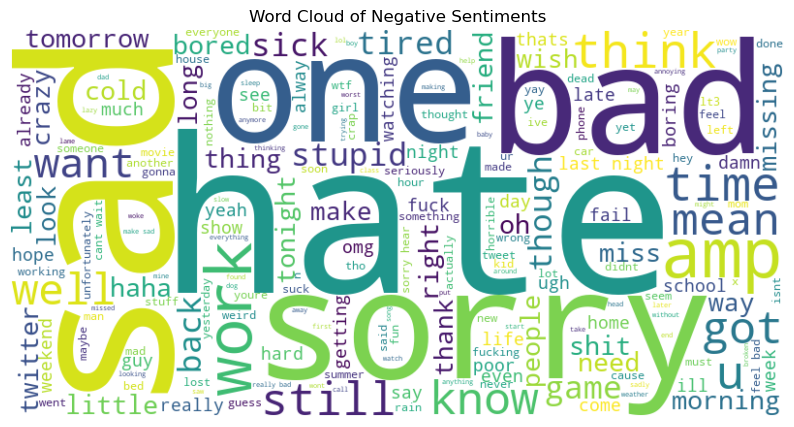

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter DataFrame to include only negative sentiments
negative_df = df[df['textblob_sentiment'] == 'Negative']

# Concatenate all text into a single string
all_text = ' '.join(negative_df['text'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Negative Sentiments')
plt.axis('off')
plt.show()


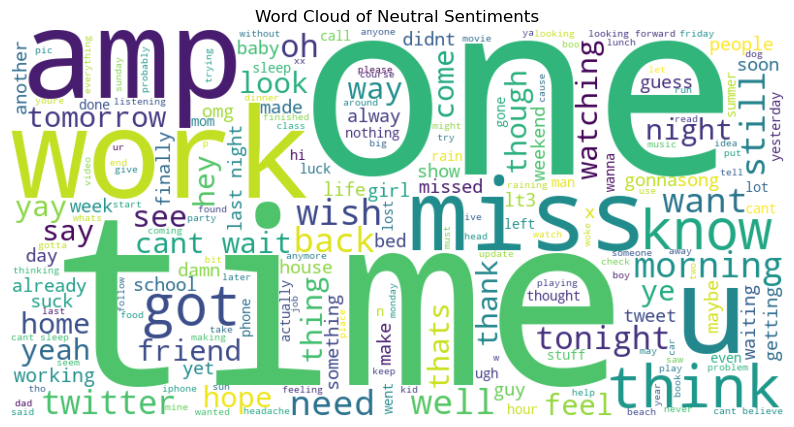

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter DataFrame to include only neutral sentiments
neutral_df = df[df['textblob_sentiment'] == 'Neutral']

# Concatenate all text into a single string
all_text = ' '.join(neutral_df['text'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Neutral Sentiments')
plt.axis('off')
plt.show()


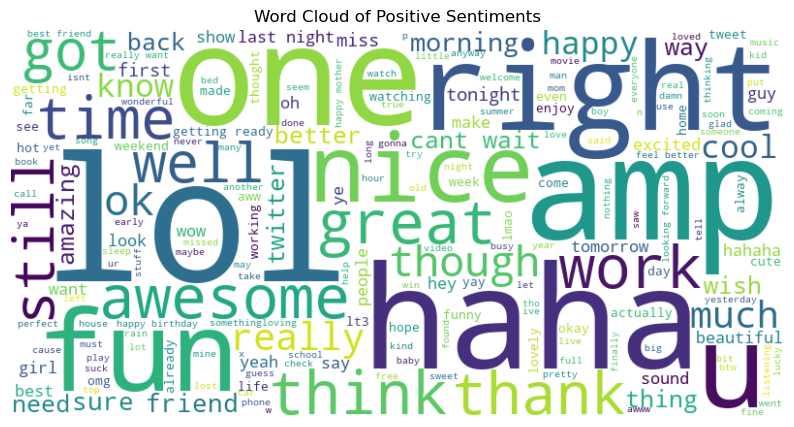

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter DataFrame to include only negative sentiments
positive_df = df[df['textblob_sentiment'] == 'Positive']

# Concatenate all text into a single string
all_text = ' '.join(positive_df['text'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Positive Sentiments')
plt.axis('off')
plt.show()


## Plot a bar graph of the sentiments distributions

In [ ]:
# Aggregate counts of sentiment categories for each day
daily_sentiment_counts = df.groupby(['date', 'textblob_sentiment']).size().unstack(fill_value=0)

#Plot using Matplotlib
plt.figure(figsize=(10, 6))
daily_sentiment_counts.plot(kind='bar', stacked=True, color=['green', 'red', 'blue'])
plt.title('Sentiment Distribution Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# USING VADER SENTIMENT ANALYSIS

In [45]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Diana\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
#Create a VADER SentimentIntensityAnalyzer instance
twitter_sentiment = SentimentIntensityAnalyzer()

#Create a function to get compound sentiment score using VADER
def get_sentiment_scores(text):
    return twitter_sentiment.polarity_scores(text)

#Apply the function to get the compound scores and store the values in vader_sentiment
df['vader_sentiment'] = df['text'].apply(get_sentiment_scores)

#Extract the 'neg', 'neu', 'pos', 'compound' scores from 'vader_sentiment'
df['vader_neg'] = df['vader_sentiment'].apply(lambda x: x['neg'])
df['vader_neu'] = df['vader_sentiment'].apply(lambda x: x['neu'])
df['vader_pos'] = df['vader_sentiment'].apply(lambda x: x['pos'])
df['vader_compound'] = df['vader_sentiment'].apply(lambda x: x['compound'])

#Create a function to categorize sentiments based on compound scores
def categorize_sentiment(vader_compound):
    if vader_compound >= 0.05:
        return 'positive'
    elif vader_compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

#Apply the categorization function to create the 'sentiment' column
df['sentiment_vader'] = df['vader_compound'].apply(categorize_sentiment)

#Display the updated DataFrame with the 'sentiment' column
print(df[['text','vader_compound','sentiment_vader']])

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter DataFrame to include only positive sentiments
positive_df = df[df['sentiment_vader'] == 'positive']

# Concatenate all text into a single string
all_text = ' '.join(positive_df['text'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Positive Sentiments')
plt.axis('off')
plt.show()


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter DataFrame to include only negative sentiments
negative_df = df[df['sentiment_vader'] == 'negative']

# Concatenate all text into a single string
all_text = ' '.join(negative_df['text'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Negative Sentiments')
plt.axis('off')
plt.show()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter DataFrame to include only neutral sentiments
neutral_df = df[df['sentiment_vader'] == 'neutral']

# Concatenate all text into a single string
all_text = ' '.join(neutral_df['text'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Neutral Sentiments')
plt.axis('off')
plt.show()


In [ ]:
#View the first 5 observations
df.head(5)

In [ ]:
#Check the variables data type
df.info()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
df.head(5)

In [ ]:
df.info()

## Drop unused variables

In [45]:
# Drop all columns that are unused
df = df[['date', 'polarity_score','sentiment_polarity','textblob_sentiment','vader_compound','sentiment_vader']]

# Display the resulting DataFrame
print(df)


KeyError: "['vader_compound', 'sentiment_vader'] not in index"

# ONE-HOT ENCODING

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# One-hot encode the sentiment_vader variable
onehot_encoder = OneHotEncoder(sparse=False)
sentiment_encoded = onehot_encoder.fit_transform(df[['sentiment_vader']])
vader_df = pd.concat([df[['date']], pd.DataFrame(sentiment_encoded, columns=onehot_encoder.categories_[0])], axis=1)

In [ ]:
vader_df.head(2)

# Split the data into training and test set

In [93]:
#Split the data into training and testing sets
train, test = train_test_split(vader_df, test_size=0.2, shuffle=False)


In [94]:
train.shape, test.shape

((1280000, 4), (320000, 4))

In [96]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [97]:
#Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

InvalidIndexError: (slice(0, 1, None), 0)

# Implement LSTM

In [ ]:
#Implement LSTM model
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(X[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10
X_train, y_train = create_dataset(train_sentiment_scaled, TIME_STEPS)
X_test, y_test = create_dataset(test_sentiment_scaled, TIME_STEPS)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

lstm_predictions_scaled = model_lstm.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Evaluate the models
arima_rmse = np.sqrt(mean_squared_error(test_sentiment, arima_predictions))
lstm_rmse = np.sqrt(mean_squared_error(test_sentiment, lstm_predictions))

print("ARIMA RMSE:", arima_rmse)
print("LSTM RMSE:", lstm_rmse)

# Make predictions for 1 day, 3 days, and 7 days ahead
def forecast_sentiment(model, data, steps):
    last_window = data[-TIME_STEPS:]
    forecast = []
    for _ in range(steps):
        prediction = model.predict(last_window.reshape(1, -1, 1))[0][0]
        forecast.append(prediction)
        last_window = np.roll(last_window, -1)
        last_window[-1] = prediction
    return forecast

# Forecast sentiment using ARIMA
arima_forecast_1day = model_arima_fit.forecast(steps=1)[0][0]
arima_forecast_3day = model_arima_fit.forecast(steps=3)[0][-1]
arima_forecast_7day = model_arima_fit.forecast(steps=7)[0][-1]

# Forecast sentiment using LSTM
lstm_forecast_1day = forecast_sentiment(model_lstm, test_sentiment_scaled[-TIME_STEPS:], 1)
lstm_forecast_3day = forecast_sentiment(model_lstm, test_sentiment_scaled[-TIME_STEPS:], 3)[-1]
lstm_forecast_7day = forecast_sentiment(model_lstm, test_sentiment_scaled[-TIME_STEPS:], 7)[-1]

print("ARIMA 1-day forecast:", arima_forecast_1day)
print("ARIMA 3-day forecast:", arima_forecast_3day)
print("ARIMA 7-day forecast:", arima_forecast_7day)
print("LSTM 1-day forecast:", lstm_forecast_1day)
print("LSTM 3-day forecast:", lstm_forecast_3day)
print("LSTM 7-day forecast:", lstm_forecast_7day)


In [ ]:
!pip install dash

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the dataset
# Assuming df contains at least two columns: 'date' and 'sentiment'

# Preprocess the data
# Ensure 'date' column is in datetime format

# Implement ARIMA model
def train_arima_model(data):
    model_arima = ARIMA(data, order=(5,1,0))
    model_arima_fit = model_arima.fit(disp=0)
    return model_arima_fit

def forecast_arima(model, steps):
    forecast = model.forecast(steps=steps)[0]
    return forecast

# Implement LSTM model
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(X[i + time_steps])
    return np.array(Xs), np.array(ys)

def train_lstm_model(data, time_steps=10):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    X, y = create_dataset(data_scaled, time_steps)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model_lstm.add(LSTM(units=50))
    model_lstm.add(Dense(units=1))

    model_lstm.compile(optimizer='adam', loss='mean_squared_error')
    model_lstm.fit(X, y, epochs=100, batch_size=32, verbose=0)
    
    return model_lstm, scaler

def forecast_lstm(model, scaler, data, steps, time_steps=10):
    forecast = []
    last_window = data[-time_steps:]
    for _ in range(steps):
        prediction = model.predict(last_window.reshape(1, -1, 1))[0][0]
        forecast.append(prediction)
        last_window = np.roll(last_window, -1)
        last_window[-1] = prediction
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div([
    dcc.Graph(id='forecast-graph'),
    html.Label('Select Model:'),
    dcc.Dropdown(
        id='model-dropdown',
        options=[
            {'label': 'ARIMA', 'value': 'arima'},
            {'label': 'LSTM', 'value': 'lstm'}
        ],
        value='arima'
    ),
    html.Label('Select Forecast Period:'),
    dcc.Dropdown(
        id='period-dropdown',
        options=[
            {'label': '1 Day', 'value': 1},
            {'label': '3 Days', 'value': 3},
            {'label': '7 Days', 'value': 7}
        ],
        value=1
    )
])

# Define callback to update the graph based on user input
@app.callback(
    Output('forecast-graph', 'figure'),
    [Input('model-dropdown', 'value'),
     Input('period-dropdown', 'value')]
)
def update_graph(selected_model, forecast_period):
    if selected_model == 'arima':
        model = train_arima_model(df['sentiment'])
        forecast = forecast_arima(model, forecast_period)
    elif selected_model == 'lstm':
        lstm_model, scaler = train_lstm_model(df['sentiment'])
        forecast = forecast_lstm(lstm_model, scaler, df['sentiment'], forecast_period)
    
    # Generate x-axis values (dates)
    dates = pd.date_range(start=df['date'].iloc[-1], periods=forecast_period + 1)[1:]
    
    # Create the plot
    fig = {
        'data': [
            {'x': dates, 'y': forecast, 'type': 'line', 'name': 'Forecast'}
        ],
        'layout': {
            'title': f'{selected_model.upper()} Forecast for {forecast_period} Days',
            'xaxis': {'title': 'Date'},
            'yaxis': {'title': 'Sentiment'}
        }
    }
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


# TIME SERIES FORECASTING